In [1]:
import mujoco
import mujoco.viewer
import numpy as np
import matplotlib.pyplot as plt

Let's create a MuJoCo model for the pendulum:

In [2]:
def create_pendulum_model():
    xml = """
    <mujoco>
        <option gravity="0 0 -9.81"/>
        <worldbody>
            <body name="pole" pos="0 0 0">
                <joint name="hinge" type="hinge" axis="0 1 0" pos="0 0 0"/>
                <geom name="pole" type="capsule" fromto="0 0 0 0 0 -1" size="0.02" mass="1"/>
                <geom name="bob" type="sphere" pos="0 0 -1" size="0.1" mass="1"/>
            </body>
        </worldbody>
        <actuator>
            <motor name="torque" joint="hinge" gear="1" ctrllimited="true" ctrlrange="-100 100"/>
        </actuator>
    </mujoco>
    """
    return mujoco.MjModel.from_xml_string(xml)

model = create_pendulum_model()
data = mujoco.MjData(model)

Now, let's implement the simulation and visualization:

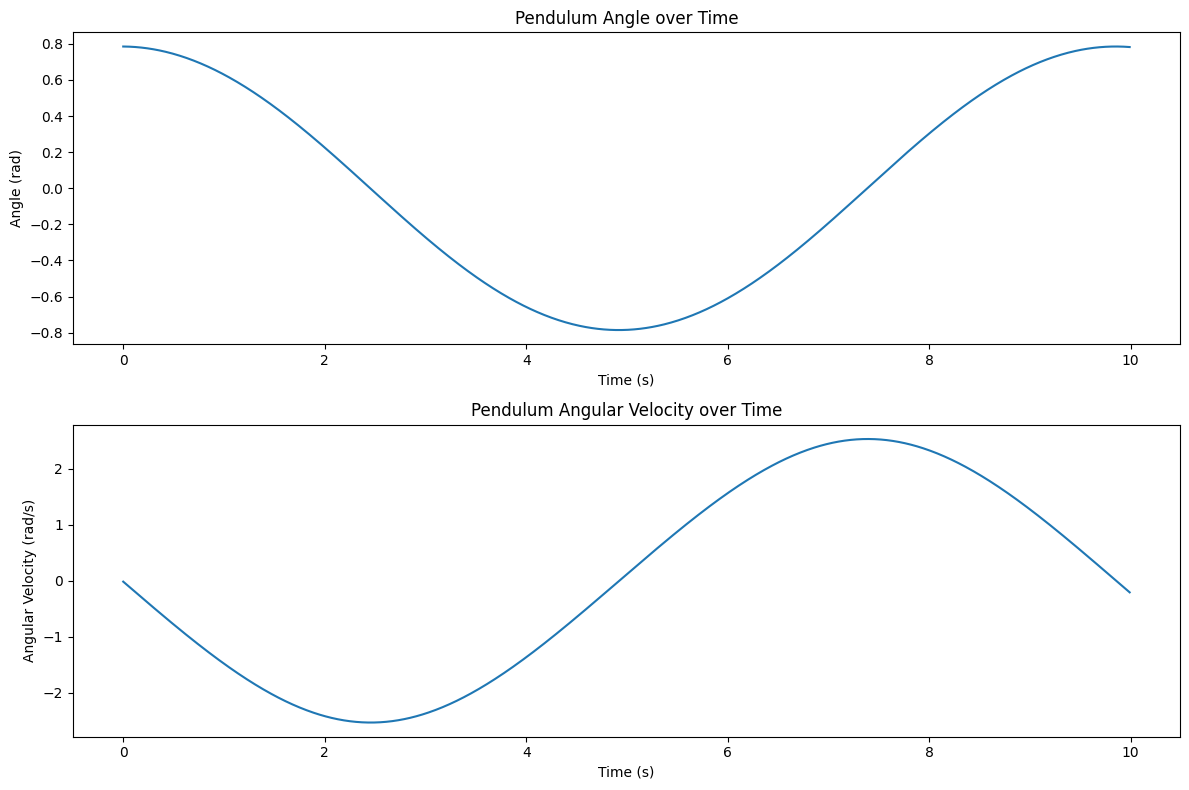

In [3]:
def simulate_pendulum(model, data, duration, dt):
    times = np.arange(0, duration, dt)
    angles = []
    velocities = []

    for t in times:
        # Set torque to 0 for free-fall
        data.ctrl[0] = 0.0

        # Step the simulation
        mujoco.mj_step(model, data)

        # Record angle and angular velocity
        angles.append(data.qpos[0])
        velocities.append(data.qvel[0])

    return times, angles, velocities


# Set initial conditions
data.qpos[0] = np.pi/4  # Initial angle (45 degrees)
data.qvel[0] = 0.0  # Initial angular velocity

# Simulation parameters
duration = 10.0  # seconds
dt = 0.01  # time step

# Run simulation
times, angles, velocities = simulate_pendulum(model, data, duration, dt)

# Visualize results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(times, angles)
plt.title('Pendulum Angle over Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')

plt.subplot(2, 1, 2)
plt.plot(times, velocities)
plt.title('Pendulum Angular Velocity over Time')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')

plt.tight_layout()
plt.show()


# Real-time visualization
with mujoco.viewer.launch_passive(model, data) as viewer:
    for t in range(int(duration / dt)):
        mujoco.mj_step(model, data)
        viewer.sync()

# Analytic Derivation of Dynamics

## Overview
this is the general method ilustrated by modern robotics book by kevin lynch

## Method
1 - we first will calculate the Pose of the end-effector using the POE formulation

In [4]:
import symforce

symforce.set_symbolic_api("sympy")

import symforce.symbolic as sf
from symforce.notebook_util import display
from symforce import geo
from symforce import values
from symforce.geo.unsupported.pose3_se3 import Pose3_SE3


Utilities Function For Cleaning Up Small Values Created by Symforce

In [5]:
import sympy as sp
from sympy import sympify, maple_code, Symbol

def remove_small_values(expr, threshold=1e-10):
    if isinstance(expr, sp.Number):
        return sp.Float(0) if abs(expr) < threshold else expr
    elif isinstance(expr, sp.Add):
        return sp.Add(*[remove_small_values(arg, threshold) for arg in expr.args])
    elif isinstance(expr, sp.Mul):
        cleaned_args = [remove_small_values(arg, threshold) for arg in expr.args]
        if any(arg == 0 for arg in cleaned_args):
            return sp.Float(0)
        return sp.Mul(*cleaned_args)
    elif isinstance(expr, sp.Pow):
        base = remove_small_values(expr.base, threshold)
        exp = remove_small_values(expr.exp, threshold)
        if exp == 0.5:  # This is a square root
            if isinstance(base, sp.Add):
                significant_terms = [term for term in base.args if not (isinstance(term, sp.Number) and abs(term) < threshold)]
                if len(significant_terms) == 0:
                    return sp.Float(0)
                elif len(significant_terms) == 1:
                    return sp.sqrt(significant_terms[0])
                else:
                    return sp.sqrt(sp.Add(*significant_terms))
            return sp.sqrt(base)
        return base ** exp
    elif isinstance(expr, (sp.sin, sp.cos, sp.tan)):
        return expr.func(remove_small_values(expr.args[0], threshold))
    else:
        return expr

def clean_expression(expr):
    if isinstance(expr, sf.Matrix44):
        cleaned_matrix = sf.Matrix44()
        for i in range(4):
            for j in range(4):
                cleaned_matrix[i, j] = remove_small_values(expr[i, j])
        return cleaned_matrix
    else:
        return remove_small_values(expr)
    
def clean_and_simplify_transformations(transformations):
    """
    Clean and simplify a list of transformations.

    Args:
    transformations (list): List of Pose3 objects representing T0i for each link.

    Returns:
    list: List of cleaned and simplified 4x4 homogeneous transformation matrices.
    """
    cleaned_transformations = []
    for T in transformations:
        # Convert Pose3 to homogeneous matrix
        matrix = T.to_homogenous_matrix()
        
        # Clean the expression
        cleaned_matrix = clean_expression(matrix)
        
        # Simplify the cleaned matrix
        simplified_matrix = cleaned_matrix.simplify()
        
        cleaned_transformations.append(simplified_matrix)

    return cleaned_transformations



In [6]:
def n_link_forward_kinematics(joint_angles: values.Values, screw_axes_params: values.Values, M_home: values.Values, epsilon: sf.Scalar):
    """
    Computes the forward kinematics for an n-link robot using the Product of Exponentials (PoE) formula,
    returning T0i for each link i from 1 to n.

    Args:
        joint_angles: A Values object containing symbolic joint angles, with keys "q1", "q2", etc.
        screw_axes_params: A Values object containing symbolic parameters for the screw axes.
                         Each key should be of the form "S{i}", where i is the joint index,
                         and the value should be a 6-vector representing the screw axis [omega_x, omega_y, omega_z, v_x, v_y, v_z].
        M_home: A Values object containing the home configurations for each link.
                Each key should be of the form "M{i}" where i is the link index (including 0 for base),
                and the value should be a Pose3 object representing the home configuration of that link relative to the base frame.
        epsilon: A small number to handle singularities in Rot3.from_tangent.

    Returns:
        A list of Pose3 objects representing T0i for each link, from i=1 to n.
    """
    def calculate_fk(current_joints, current_axes, M_end):
        T = M_end

        # Compute the product of exponentials in reverse order
        for i in range(len(current_joints), 0, -1):
            S = current_axes[f"S{i}"]
            q = current_joints[f"q{i}"]
            se3_element = sf.Matrix61(S * q)
            pose3_se3 = Pose3_SE3.from_tangent(se3_element, epsilon=epsilon)
            pose3 = sf.Pose3(R=pose3_se3.R, t=pose3_se3.t)
            T = pose3 * T  # Left multiply

        return T

    def recursive_fk(current_joints, current_axes, current_M_end):
        if len(current_joints) == 0:
            return []

        T0i = calculate_fk(current_joints, current_axes, current_M_end)
        
        if len(current_joints) > 1:
            # Get the home configuration of the previous link
            prev_M_home = M_home[f"M{len(current_joints)-1}"]
            
            T0i_prev = recursive_fk(
                values.Values(**{f"q{i}": current_joints[f"q{i}"] for i in range(1, len(current_joints))}),
                values.Values(**{f"S{i}": current_axes[f"S{i}"] for i in range(1, len(current_axes))}),
                prev_M_home
            )
        else:
            T0i_prev = []

        return T0i_prev + [T0i]

    # Start with full forward kinematics
    return recursive_fk(joint_angles, screw_axes_params, M_home[f"M{len(joint_angles)}"])

# Example usage:
# joint_angles = values.Values(q1=sf.Symbol("q1",positive=True), q2=sf.Symbol("q2",positive=True), q3=sf.Symbol("q3",positive=True))  # Example for a 3-link robot
# screw_axes_params = values.Values(
#     S1=sf.V6([0, 0, 1, 0, 0, 0]),  # Example screw axis for joint 1
#     S2=sf.V6([0, 0, 1, 0, 1, 0]),  # Example screw axis for joint 2
#     S3=sf.V6([0, 1, 0, 0, 0, 1])   # Example screw axis for joint 3
# )
# M_home = values.Values(
#     M1=geo.Pose3(R=geo.Rot3.identity(), t=sf.V3([0, 0, sf.Symbol("L1", positive=True)])),
#     M2=geo.Pose3(R=geo.Rot3.identity(), t=sf.V3([0, 0, sf.Symbol("L1", positive=True) + sf.Symbol("L2", positive=True)])),
#     M3=geo.Pose3(R=geo.Rot3.identity(), t=sf.V3([0, 0, sf.Symbol("L1", positive=True) + sf.Symbol("L2", positive=True) + sf.Symbol("L3", positive=True)]))
# )
# epsilon = sf.numeric_epsilon

# T0i = n_link_forward_kinematics(joint_angles, screw_axes_params, M_home, epsilon)

# # Clean and simplify the transformations
# cleaned_T0i = clean_and_simplify_transformations(T0i)

# print("Cleaned and Simplified Forward Kinematics Transformations:")
# for i, Ti in enumerate(cleaned_T0i, start=1):
#     print(f"T0{i}:")
#     display(Ti)
#     print()


using the mujoco's defined refrence frame . we can calculate the Transformation matrix for the mass as follow


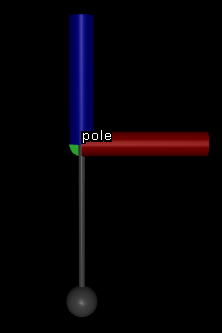

This is a auxilary function used for removing small values in symbolic expressions

Pose matrix for pendulum

In [7]:
def create_revolute_joint(axis, point):
    """Create a screw axis for a revolute joint."""
    omega = sf.V3(axis)
    p = sf.V3(point)
    v = -omega.cross(p)
    return sf.V6(omega.to_flat_list() + v.to_flat_list())

def create_prismatic_joint(axis):
    """Create a screw axis for a prismatic joint."""
    v = sf.V3(axis)
    omega = sf.V3([0, 0, 0])
    return sf.V6(omega.to_flat_list() + v.to_flat_list())

def create_robot_model(joint_types, joint_axes, link_lengths, joint_points=None):
    """
    Create a robot model with specified joint types, parameters, link lengths, and initial transformation.
    
    Args:
    joint_types (list): List of joint types ('revolute' or 'prismatic')
    joint_axes (list): List of joint axes
    link_lengths (dict): Dictionary of link lengths (e.g., {'L0': 1.0, 'L1': 0.5})
    M_params (dict): Dictionary with 'R' (rotation) and 't' (translation) for initial transformation
    joint_points (list, optional): List of joint points for revolute joints. Defaults to None.
    
    Returns:
    tuple: joint_angles, S, M
    """
    num_joints = len(joint_types)
    
    if joint_points is None:
        joint_points = [[0, 0, 0]] * num_joints

    # Define symbolic joint angles
    joint_angles = values.Values()
    for i in range(num_joints):
        joint_angles[f"q{i+1}"] = sf.Symbol(f"q{i+1}", positive=True)

    # Create screw axes
    S = values.Values()
    for i in range(num_joints):
        if joint_types[i].lower() == 'revolute':
            S[f"S{i+1}"] = create_revolute_joint(joint_axes[i], joint_points[i])
        elif joint_types[i].lower() == 'prismatic':
            S[f"S{i+1}"] = create_prismatic_joint(joint_axes[i])
        else:
            raise ValueError(f"Unknown joint type: {joint_types[i]}")

    # Create initial end-effector transformation
  # R = geo.Rot3.from_yaw_pitch_roll(*M_params['R'])
    # t = geo.V3(M_params['t'])
    # M = geo.Pose3(R=R, t=t)  

    return joint_angles, S, link_lengths

# Usage example for a pendulum (revolute joint)
joint_types = ['revolute']
joint_axes = [[0, 1, 0]]
joint_points = [[0, 0, 0]]
link_lengths = {'L0': sf.Symbol("L0", positive=True)}
M_home = values.Values(
    M1=geo.Pose3(R=geo.Rot3.identity(), t=sf.V3([0, 0, -link_lengths['L0']]))  # End-effector frame
)

joint_angles, S, link_lengths = create_robot_model(
    joint_types, joint_axes, link_lengths, joint_points)

display("Pendulum Model:")
display("Joint angles:")
display(joint_angles)
display("Screw axes:")
display(S)
display("Initial transformation:")
display(M_home)

# Usage example for a robot with both revolute and prismatic joints
scara_joint_types = ['revolute', 'revolute', 'revolute','prismatic']
scara_joint_axes = [[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 0]]
scara_link_lengths = {'L0': sf.Symbol("L0", positive=True), 'L1': sf.Symbol("L1", positive=True), 'L2': sf.Symbol("L2", positive=True)}
scara_joint_points = [[0, 0, 0], [scara_link_lengths['L1'],0,0], [scara_link_lengths['L1']+scara_link_lengths['L2'], 0, 0],[0,0,1]]
scara_M_home = values.Values(
    M1=geo.Pose3(R=geo.Rot3.identity(), t=sf.V3([scara_link_lengths["L1"], 0, scara_link_lengths["L0"]])),  # Base frame
    M2=geo.Pose3(R=geo.Rot3.identity(), t=sf.V3([scara_link_lengths["L1"]+scara_link_lengths["L2"], 0, scara_link_lengths["L0"]])),
    M3=geo.Pose3(R=geo.Rot3.identity(), t=sf.V3([scara_link_lengths["L1"]+scara_link_lengths["L2"], 0, scara_link_lengths["L0"]])),
    M4=geo.Pose3(R=geo.Rot3.identity(), t=sf.V3([scara_link_lengths["L1"]+scara_link_lengths["L2"], 0, scara_link_lengths["L0"]+sf.Symbol("q4",positive=True)])),

)

scara_joint_angles, scara_S, scara_M = create_robot_model(
    scara_joint_types, scara_joint_axes, scara_link_lengths,scara_joint_points)

display("\nMixed Joint Robot Model:")
display("Joint angles:")
display(scara_joint_angles)
display("Screw axes:")
display(scara_S)
display("Initial transformation:")
display(scara_M)

'Pendulum Model:'

'Joint angles:'

Values(
  q1: q1,
)

'Screw axes:'

Values(
  S1: Matrix([
[0],
[1],
[0],
[0],
[0],
[0]]),
)

'Initial transformation:'

Values(
  M1: <Pose3 R=<Rot3 <Q xyzw=[0, 0, 0, 1]>>, t=(0, 0, -L0)>,
)

'\nMixed Joint Robot Model:'

'Joint angles:'

Values(
  q1: q1,
  q2: q2,
  q3: q3,
  q4: q4,
)

'Screw axes:'

Values(
  S1: Matrix([
[0],
[0],
[1],
[0],
[0],
[0]]),
  S2: Matrix([
[  0],
[  0],
[  1],
[  0],
[-L1],
[  0]]),
  S3: Matrix([
[       0],
[       0],
[       1],
[       0],
[-L1 - L2],
[       0]]),
  S4: Matrix([
[0],
[0],
[0],
[0],
[0],
[0]]),
)

'Initial transformation:'

{'L0': L0, 'L1': L1, 'L2': L2}

Forward Kinematics

Cleaned and Simplified Forward Kinematics Transformations:
T01:


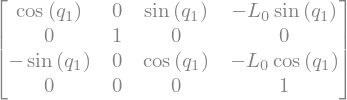

In [8]:
# Use the n_link_forward_kinematics function to get the transformations
T0i = n_link_forward_kinematics(joint_angles, S, M_home, sf.numeric_epsilon)

# Clean and simplify the transformations
cleaned_T0i = clean_and_simplify_transformations(T0i)

print("Cleaned and Simplified Forward Kinematics Transformations:")
for i, Ti in enumerate(cleaned_T0i, start=1):
    print(f"T0{i}:")
    display(Ti)
    print()

This is a scara Robot used only for Testing Purposes

Cleaned and Simplified Forward Kinematics Transformations:
T01:


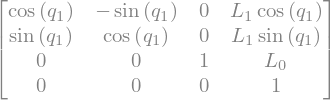


T02:


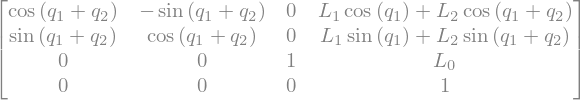


T03:


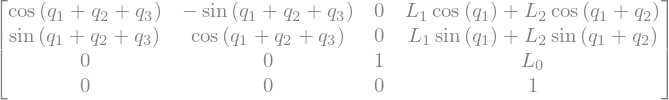


T04:


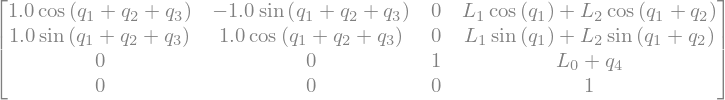

In [9]:
# Use the n_link_forward_kinematics function to get the transformations
T0i_scara = n_link_forward_kinematics(scara_joint_angles, scara_S, scara_M_home, sf.numeric_epsilon)

# Clean and simplify the transformations
cleaned_T0i_scara = clean_and_simplify_transformations(T0i_scara)

print("Cleaned and Simplified Forward Kinematics Transformations:")
for i, Ti in enumerate(cleaned_T0i_scara, start=1):
    print(f"T0{i}:")
    display(Ti)
    print()

**Mathematical Explanation for deriving space Jacobian**


1. **Determine Forward Kinematics:**  Establish the forward kinematics of your robot using the product of exponentials formula. Identify the screw axes `Si` and the home configuration `M`.
2. **Calculate Spatial Twist:** Differentiate the forward kinematics equation with respect to time to get the expression for the spatial twist `[Vs]`.
3. **Find Columns of Jacobian:**  For each joint *i*:
    * Calculate the transformation `Ti-1 = e^[S1]θ1 * ... * e^[Si-1]θi-1` that represents the movement of the first (i - 1) joints from their zero position to their current values.
    * Apply the adjoint transformation to the screw axis `Si`: `Jsi(θ) = Ad[Ti-1](Si)`. This gives you the screw vector representing joint axis *i* for arbitrary joint values, expressed in the fixed base frame.





Pendulum Spatial Twist:


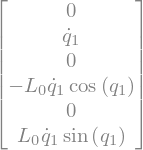


Pendulum Space Jacobian:


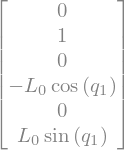

In [19]:
def calculate_spatial_twist(T:sf.Pose3, joint_angles):
    """
    Calculate the spatial twist by differentiating the forward kinematics.
    
    Args:
    T (geo.Pose3): Forward kinematics transformation.
    joint_angles (values.Values): Values object containing symbolic joint angles.
    
    Returns:
    sf.Matrix: Spatial twist
    """
   

    # Create symbolic joint angles and velocities using values.Values
    qdots = values.Values()

    for i in range(len(joint_angles)):
        qdots[f"qdot{i+1}"] = sf.Symbol(f"qdot{i+1}")
    
    # Calculate the time derivative of T
    T_dot = sf.Matrix44.zero()
    for i, (q, qdot) in enumerate(zip(joint_angles, qdots)):
        T_dot += T.diff(joint_angles[q]) * qdots[qdot]
    
    # Calculate the spatial twist
    Vs = T_dot * T.inv()
    Vs = Vs.simplify()
    
      # Extract the angular velocity components (first three elements)
    omega = sf.V3(Vs[2, 1], Vs[0, 2], Vs[1, 0])
    
    # Calculate the linear velocity components
    v = omega.cross(T[:3, 3])  # Cross product of angular velocity with the position vector
    
    # Combine angular and linear velocities into a 6x1 twist vector
    twist = sf.Matrix61(omega.to_flat_list() + v.to_flat_list())

    
    return twist

def calculate_body_twist(T, joint_angles):
    """
    Calculate the body twist by transforming the spatial twist.
    
    Args:
    T (sf.Matrix44): Forward kinematics transformation matrix.
    joint_angles (values.Values): Values object containing symbolic joint angles.
    
    Returns:
    sf.Matrix: Body twist
    """
    
    # Calculate spatial twist
    spatial_twist = calculate_spatial_twist(T, joint_angles)
    
    # Extract rotation matrix and translation vector from T
    R = T[:3, :3]
    p = T[:3, 3]
    p_skew = sf.Matrix33.skew_symmetric(p)
    
    # Construct the adjoint transformation matrix
    Ad_T_bs = sf.Matrix66.zero()
    Ad_T_bs[:3, :3] = R.T
    Ad_T_bs[3:, 3:] = R.T
    Ad_T_bs[3:, :3] = -R.T * p_skew 
    
    # Transform spatial twist to body twist
    body_twist = Ad_T_bs * spatial_twist
    
    # Simplify the result
    body_twist = body_twist.simplify()
    
    return body_twist


def extract_jacobian_from_twist(twist, qdots):
    """
    Extract the Space Jacobian from the spatial twist.
    
    Args:
    twist (sf.Matrix): Spatial twist.
    qdots (values.Values): Values object containing symbolic joint velocities.
    
    Returns:
    sf.Matrix: Space Jacobian
    """
    n = len(qdots)
    Js = sf.Matrix(6, n)
    
    for i in range(6):  # 6 rows for the spatial twist
        for j, qdot in enumerate(qdots.values()):
            Js[i, j] = twist[i].coeff(qdot)
    
    return Js

def calculate_body_jacobian(T, joint_angles):
    """
    Calculate the body Jacobian J_ib.
    
    Args:
    T (geo.Pose3): Forward kinematics transformation.
    joint_angles (values.Values): Values object containing symbolic joint angles.
    
    Returns:
    sf.Matrix: Body Jacobian J_ib
    """
    # Calculate body twist
    body_twist = calculate_body_twist(T, joint_angles)
    
    # Create symbolic joint velocities
    qdots = values.Values()
    for i in range(len(joint_angles)):
        qdots[f"qdot{i+1}"] = sf.Symbol(f"qdot{i+1}")
    
    # Extract Jacobian from body twist
    J_ib = extract_jacobian_from_twist(body_twist, qdots)
    
    return J_ib
# Define symbolic joint angle and its derivative
 
# Create symbolic joint angles and velocities using values.Values
qdots = values.Values()

for i in range(len(joint_angles)):
    qdots[f"qdot{i+1}"] = sf.Symbol(f"qdot{i+1}")
# Define screw axis (rotation around y-axis)
S=values.Values(S1=S["S1"])
# Define end-effector pose at home position (straight down)


# Define end-effector pose at home position (straight down)

# Calculate spatial twist
twist = calculate_spatial_twist(cleaned_T0i[-1], joint_angles)
print("\nPendulum Spatial Twist:")
display(twist)

# Extract Space Jacobian from twist
Js_pendulum = extract_jacobian_from_twist(twist, qdots)
print("\nPendulum Space Jacobian:")
display(Js_pendulum)

J_ib = calculate_body_jacobian(cleaned_T0i[-1], joint_angles)

display("Body Jacobian J_ib:")
display(J_ib)

Body Twist (Direct Calculation):


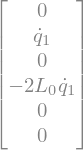


Body Twist (Derived from Spatial Twist):


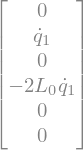


Difference:


In [11]:
def verify_body_twist(T, joint_angles):
    """
    Verify the body twist by transforming the spatial twist.
    
    Args:
    T (sf.Matrix44): Forward kinematics transformation matrix.
    joint_angles (values.Values): Values object containing symbolic joint angles.
    
    Returns:
    tuple: (Body twist calculated directly, Body twist derived from spatial twist)
    """
    
    # Calculate spatial twist
    spatial_twist = calculate_spatial_twist(T, joint_angles)
    
    # Calculate body twist directly
    body_twist_direct = calculate_body_twist(T, joint_angles)
    
    # Extract rotation matrix and translation vector from T
    R = T[:3, :3]
    p = T[:3, 3]
    p_skew = sf.Matrix33.skew_symmetric(p)
    
    # Construct the adjoint transformation matrix
    Ad_T = sf.Matrix66.zero()
    Ad_T[:3, :3] = R
    Ad_T[3:, 3:] = R
    Ad_T[3:, :3] = p_skew * R
    
    # Transform spatial twist to body twist
    body_twist_from_spatial = Ad_T.inv() * spatial_twist
    
    # Simplify the result
    body_twist_from_spatial = body_twist_from_spatial.simplify()
    
    return body_twist_direct, body_twist_from_spatial

# Use the verification function
body_twist_direct, body_twist_from_spatial = verify_body_twist(cleaned_T0i[-1], joint_angles)

print("Body Twist (Direct Calculation):")
display(body_twist_direct)

print("\nBody Twist (Derived from Spatial Twist):")
display(body_twist_from_spatial)

print("\nDifference:")
display((body_twist_direct - body_twist_from_spatial).simplify())

Cleaned and Simplified Forward Kinematics Transformations and Body Jacobians:
T01:


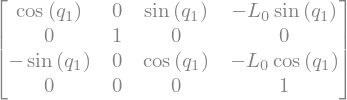


J_b1:


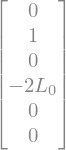

In [12]:
def calculate_body_jacobians(T0i_list, joint_angles, screw_axes_params):
    """
    Calculates the body Jacobian for each transformation in T0i_list.

    Args:
    T0i_list (list): List of Pose3 objects representing T0i for each link.
    joint_angles (values.Values): Values object containing symbolic joint angles.
    screw_axes_params (values.Values): Values object containing screw axes parameters.

    Returns:
    list: List of body Jacobians corresponding to each T0i, all of the same size.
    """
    n = len(T0i_list)  # Total number of joints
    J_bi_list = []
    
    for i, T in enumerate(T0i_list, start=1):
        # Create a Values object with joint angles up to the current link
        current_joint_angles = values.Values(**{f"q{j}": joint_angles[f"q{j}"] for j in range(1, i+1)})
        
        # Calculate the body Jacobian for the current transformation
        J_bi = calculate_body_jacobian(T, current_joint_angles)
        
        # Create a new matrix of the correct size (6 x n) filled with zeros
        J_bi_padded = sf.Matrix.zeros(6, n)
        
        # Fill in the calculated Jacobian columns
        for col in range(J_bi.cols):
            J_bi_padded[:, col] = J_bi[:, col]
        
        J_bi_list.append(J_bi_padded)
    
    return J_bi_list


J_ib_list=calculate_body_jacobians(cleaned_T0i,joint_angles,S)
# Example usage:
# Assuming we have already calculated T0i_list


# Now let's use this function along with the existing n_link_forward_kinematics

# First, calculate the forward kinematics

# Then, calculate the body Jacobians
# J_bi_list = calculate_body_jacobians(cleaned_T0i, joint_angles, screw_axes_params)

# Clean and simplify the transformations and Jacobians
# cleaned_T0i = clean_and_simplify_transformations(T0i)
# cleaned_J_bi = [clean_expression(J_bi).simplify() for J_bi in J_bi_list]

print("Cleaned and Simplified Forward Kinematics Transformations and Body Jacobians:")
for i, (Ti, J_bi) in enumerate(zip(cleaned_T0i, J_ib_list), start=1):
    print(f"T0{i}:")
    display(Ti)
    print(f"\nJ_b{i}:")
    display(J_bi)
    print()



# Deriving Robot Dynamics: A Unified Approach

1. **System Description:**
   - Consider an n-link robot with joint angles θ ∈ ℝⁿ.
   - Each link i has a spatial inertia matrix Gi expressed in its local frame.

2. **Kinematics:**
   - Define T0i(θ1, ..., θi) as the forward kinematics from the base frame {0} to link frame {i}.
   - Calculate the body Jacobian Jib(θ) for each link from T0i^(-1)Ṫ0i.

3. **Mass Matrix:**
   - Construct the robot's mass matrix M(θ) by combining the individual link inertias:
     ```
     M(θ) = ∑i Jib^T(θ) Gi Jib(θ)
     ```

4. **Kinetic Energy:**
   - Express the total kinetic energy as:
     ```
     K = (1/2) θ̇^T M(θ) θ̇
     ```

5. **Potential Energy:**
   - Calculate the potential energy P(θ) due to gravity for each link.

6. **Lagrangian:**
   - Form the Lagrangian L = K - P.

7. **Equations of Motion:**
   - Apply the Euler-Lagrange equation to derive the dynamics:
     ```
     d/dt(∂L/∂θ̇i) - ∂L/∂θi = τi
     ```
   - This results in the general form:
     ```
     τ = M(θ)θ̈ + C(θ,θ̇)θ̇ + g(θ)
     ```
     where C(θ,θ̇)θ̇ represents Coriolis and centrifugal terms, and g(θ) represents gravity terms.


Lagrangian:


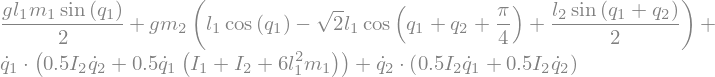


Equations of Motion:
Joint 1:


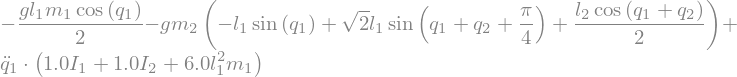

Joint 2:


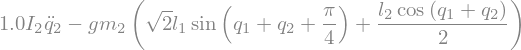

Spatial Inertia Matrix for Point Mass Pendulum:
Matrix([
[   0,     0, 0,     0, L0*m, 0],
[   0,     0, 0, -L0*m,    0, 0],
[   0,     0, 0,     0,    0, 0],
[   0, -L0*m, 0,     m,    0, 0],
[L0*m,     0, 0,     0,    m, 0],
[   0,     0, 0,     0,    0, m]])


In [13]:
def calculate_lagrangian(robot_model, joint_angles, joint_velocities):
    """
    Calculate the Lagrangian L = T - V for a robot.
    
    Args:
    robot_model (dict): A dictionary containing robot parameters
    joint_angles (values.Values): Symbolic joint angles
    joint_velocities (values.Values): Symbolic joint velocities
    
    Returns:
    sp.Expr: Lagrangian expression
    """
    # Calculate kinetic energy
    T = calculate_kinetic_energy(robot_model, joint_angles, joint_velocities)
    
    # Calculate potential energy
    V = calculate_potential_energy(robot_model, joint_angles)
    
    # Lagrangian
    L = T - V
    
    return L


def calculate_mass_matrix(robot_model, J_bi_list):
    """
    Calculate the Mass Matrix M(θ) for a robot.
    
    Args:
    robot_model (dict): A dictionary containing robot parameters:
        - 'links' (list): List of link parameters, each containing:
            - 'G' (sf.Matrix66): Spatial inertia matrix for this link
    J_bi_list (list): List of body Jacobians for each link, each as an sf.Matrix
    
    Returns:
    sf.Matrix: Mass Matrix M(θ)
    """
    n = J_bi_list[-1].cols  # Number of joints is the number of columns in the last Jacobian
    M = sf.Matrix.zeros(n, n)
    
    for link, J_bi in zip(robot_model['links'], J_bi_list):
        # Get spatial inertia matrix for this link
        G = link['G']
        
        # Add contribution of this link to the mass matrix
        M += J_bi.transpose() * G * J_bi
    
    return M.simplify()

# Helper function to create a spatial inertia matrix
def create_spatial_inertia_matrix(mass, com, I):
    """
    Create a spatial inertia matrix.
    
    Args:
    mass (float): Mass of the link
    com (sf.V3): Center of mass of the link in link frame
    I (sf.Matrix33): 3x3 rotational inertia matrix about the center of mass
    
    Returns:
    sf.Matrix66: Spatial inertia matrix
    """
    # C = sf.Matrix33.skew_symmetric(com)
    # G = sf.Matrix66.zero()
    # G[:3, :3] = I + mass * C * C.transpose()
    # G[:3, 3:] = mass * C
    # G[3:, :3] = mass * C.transpose()
    # G[3:, 3:] = mass * sf.Matrix33.eye(3,3)

    C = sf.Matrix33.skew_symmetric(com)
    G = sf.Matrix66.zero()
    G[:3, :3] = I  # Inertia tensor in upper-left corner
    G[:3, 3:] = mass * C
    G[3:, :3] = -mass * C
    G[3:, 3:] = mass * sf.Matrix33.eye(3,3)  # Mass matrix in lower-right corner
    
    return G
    


# def calculate_kinetic_energy(robot_model, joint_angles, joint_velocities):
#     """Calculate the total kinetic energy of the robot."""
#     M = calculate_mass_matrix(robot_model, joint_angles)
#     q_dot = sp.Matrix([joint_velocities[f'qdot{i+1}'] for i in range(len(joint_angles))])
#     T = 0.5 * q_dot.T * M * q_dot
#     return T[0]  # Convert 1x1 matrix to scalar


def calculate_kinetic_energy(robot_model, J_bi_list, joint_velocities):
    """
    Calculate the total kinetic energy of the robot.
    
    Args:
    robot_model (dict): A dictionary containing robot parameters.
    J_bi_list (list): List of body Jacobians for each link, each as an sf.Matrix.
    joint_velocities (values.Values): Values object containing symbolic joint velocities.
    
    Returns:
    sf.Scalar: Total kinetic energy of the robot.
    """
    # Calculate the mass matrix using the new definition
    M = calculate_mass_matrix(robot_model, J_bi_list)
    
    # Create a vector of joint velocities
    q_dot = sf.Matrix([joint_velocities[f'qdot{i+1}'] for i in range(len(J_bi_list))])
    
    # Calculate kinetic energy
    T = 0.5 * q_dot.T * M * q_dot
    
    return T[0, 0]  # Convert 1x1 matrix to scalar


def calculate_potential_energy(robot_model, T0i_list):
    """
    Calculate the total potential energy of the robot.
    
    Args:
    robot_model (dict): A dictionary containing robot parameters.
    T0i_list (list): List of Pose3 objects representing the transformations from base to each link.
    
    Returns:
    sf.Scalar: Total potential energy of the robot.
    """
    V = sf.Matrix11([[0]])
    g = sf.V3(0, -sf.Symbol("g", positive=True), 0)  # Gravity vector
    
    for i, (link, T) in enumerate(zip(robot_model['links'], T0i_list)):
        G = link['G']  # Spatial inertia matrix
        
        # Extract mass and center of mass from the spatial inertia matrix
        m = G[3, 3]  # Mass is in the (3,3) element of the spatial inertia matrix
        com_local = sf.V4(G[1, 5] / m, G[2, 3] / m, G[0, 4] / m, 1)  # Extract COM from off-diagonal elements and make it homogeneous
        
        # Transform COM to world frame
        com_world = T * com_local
        
        # Calculate potential energy
        V += m * g.T * com_world[:3]
    
    return V[0]  # Convert 1x1 matrix to scalar


def derive_equations_of_motion(L, joint_angles, joint_velocities):
    """
    Derive the equations of motion using the Euler-Lagrange equation.
    
    Args:
    L (sp.Expr): Lagrangian expression
    joint_angles (values.Values): Symbolic joint angles
    joint_velocities (values.Values): Symbolic joint velocities
    
    Returns:
    list: List of equations of motion for each joint
    """
    eom = []
    t = sf.Symbol('t')
    
    for i in range(len(joint_angles)):
        q = joint_angles[f'q{i+1}']
        q_dot = joint_velocities[f'qdot{i+1}']
        
        # Partial derivative with respect to q_dot
        dL_dq_dot = L.diff(q_dot)
        
        # Time derivative of partial derivative with respect to q_dot
        d_dt_dL_dq_dot = dL_dq_dot.diff(q) * q_dot + dL_dq_dot.diff(q_dot) * sf.Symbol(f'qddot{i+1}')
        
        # Partial derivative with respect to q
        dL_dq = L.diff(q)
        
        # Euler-Lagrange equation
        eq = d_dt_dL_dq_dot - dL_dq
        
        eom.append(eq)
    
    return eom

# Example usage
def example_lagrangian_derivation():
    # Define symbolic variables
    q1, q2 = sf.Symbol('q1',positive=True), sf.Symbol('q2',positive=True)
    qdot1, qdot2 = sf.Symbol('qdot1'), sf.Symbol('qdot2')
    m1, m2, l1, l2, g = sf.Symbol('m1',positive=True), sf.Symbol('m2',positive=True), sf.Symbol('l1',positive=True), sf.Symbol('l2',positive=True), sf.Symbol('g',positive=True)
    I1, I2 = sf.Symbol('I1'), sf.Symbol('I2')
    
    # Create joint angles and velocities
    joint_angles = values.Values(q1=q1, q2=q2)
    joint_velocities = values.Values(qdot1=qdot1, qdot2=qdot2)
    
    # Create screw axes
    screw_axes_params = values.Values(
        S1=sf.V6([0, 0, 1, 0, 0, 0]),
        S2=sf.V6([0, 0, 1, l1, 0, 0])
    )
    
    # Create home configurations
    M_home = values.Values(
        M1=geo.Pose3(R=geo.Rot3.identity(), t=sf.V3([l1, 0, 0])),
        M2=geo.Pose3(R=geo.Rot3.identity(), t=sf.V3([l1 + l2, 0, 0]))
    )
    
    # Calculate forward kinematics
    T0i_list = n_link_forward_kinematics(joint_angles, screw_axes_params, M_home, sf.numeric_epsilon)
    
    # Clean and simplify the transformations
    T0i_list_cleaned = clean_and_simplify_transformations(T0i_list)

    # Calculate body Jacobians
    J_bi_list = calculate_body_jacobians(T0i_list_cleaned, joint_angles, screw_axes_params)
    
    # Create robot model with spatial inertia matrices
    robot_model = {
        'links': [
            {'G': create_spatial_inertia_matrix(m1, sf.V3([l1/2, 0, 0]), sf.Matrix33.diag([0, 0, I1]))},
            {'G': create_spatial_inertia_matrix(m2, sf.V3([l2/2, 0, 0]), sf.Matrix33.diag([0, 0, I2]))}
        ]
    }
    
    # Calculate kinetic energy
    T = calculate_kinetic_energy(robot_model, J_bi_list, joint_velocities)
    
    # Calculate potential energy
    V = calculate_potential_energy(robot_model, T0i_list_cleaned)

    # Calculate Lagrangian
    L = T - V
    
    print("Lagrangian:")
    display(L)
    
    # Derive equations of motion
    eom = derive_equations_of_motion(L, joint_angles, joint_velocities)
    
    print("\nEquations of Motion:")
    for i, eq in enumerate(eom):
        print(f"Joint {i+1}:")
        display(eq)

# Run the example
example_lagrangian_derivation()
# Run the example
# example_lagrangian_derivation()

# Define symbols
m = sf.Symbol("m")  # Mass of the bob
L0 = sf.Symbol("L0")  # Length of the pendulum

# For a point mass pendulum:
# The center of mass is at the end of the rod
com = sf.V3(0, 0, -L0)

# The moment of inertia for a point mass about its center is zero
I = sf.Matrix33.zero()

# Create the spatial inertia matrix
G_point_mass = create_spatial_inertia_matrix(m, com, I)

print("Spatial Inertia Matrix for Point Mass Pendulum:")
print(G_point_mass)

Pendulum equations of motions

Joint Angles:


Values(
  q1: q1,
)


Screw Axes Parameters:


Values(
  S1: Matrix([
[0],
[1],
[0],
[0],
[0],
[0]]),
)


Joint Velocities:


Values(
  qdot1: qdot1,
)


Home Configurations:


Values(
  M1: <Pose3 R=<Rot3 <Q xyzw=[0, 0, 0, 1]>>, t=(0, 0, -L0)>,
)


Forward Kinematics:
T01:


<Pose3 R=<Rot3 <Q xyzw=[0, q1*sin(sqrt(q1**2 + 4.93038065763132e-30)/2)/sqrt(q1**2 + 4.93038065763132e-30), 0, cos(sqrt(q1**2 + 4.93038065763132e-30)/2)]>>, t=(-2*L0*q1*sin(sqrt(q1**2 + 4.93038065763132e-30)/2)*cos(sqrt(q1**2 + 4.93038065763132e-30)/2)/sqrt(q1**2 + 4.93038065763132e-30), 0, -L0*(-2*q1**2*sin(sqrt(q1**2 + 4.93038065763132e-30)/2)**2/(q1**2 + 4.93038065763132e-30) + 1))>


Cleaned and Simplified Forward Kinematics:
T01:


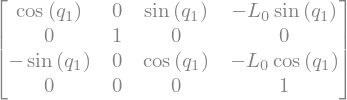


Body Jacobians:
J_b1:


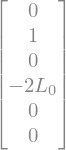


Spatial Inertia Matrix:


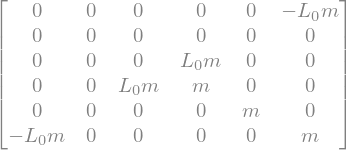


Kinetic Energy:



Potential Energy:



Lagrangian:



Equation of Motion:


In [14]:
def example_lagrangian_derivation_pendulum():
    # Define robot parameters for a one-link pendulum
    joint_types = ['revolute']
    joint_axes = [[0, 1, 0]]
    joint_points = [[0, 0, 0]]
    link_lengths = {'L0': sf.Symbol("L0", positive=True)}
    

    # Create robot model
    joint_angles, screw_axes_params, _ = create_robot_model(joint_types, joint_axes, link_lengths, joint_points)
    
    print("Joint Angles:")
    display(joint_angles)
    print("\nScrew Axes Parameters:")
    display(screw_axes_params)

    # Create joint velocities
    joint_velocities = values.Values()
    joint_velocities['qdot1'] = sf.Symbol('qdot1')
    
    print("\nJoint Velocities:")
    display(joint_velocities)

    # Create home configurations
    M_home = values.Values(
    M1=geo.Pose3(R=geo.Rot3.identity(), t=sf.V3([0, 0, -link_lengths['L0']]))  # End-effector frame
    )
    
    print("\nHome Configurations:")
    display(M_home)

    # Calculate forward kinematics
    T0i_list = n_link_forward_kinematics(joint_angles, screw_axes_params, M_home, sf.numeric_epsilon)
    
    print("\nForward Kinematics:")
    for i, T in enumerate(T0i_list):
        print(f"T0{i+1}:")
        display(T)

    # Clean and simplify the transformations
    T0i_list_cleaned = clean_and_simplify_transformations(T0i_list)
    
    print("\nCleaned and Simplified Forward Kinematics:")
    for i, T in enumerate(T0i_list_cleaned):
        print(f"T0{i+1}:")
        display(T)

    # Calculate body Jacobians
    J_bi_list = calculate_body_jacobians(T0i_list_cleaned, joint_angles, screw_axes_params)
    
    print("\nBody Jacobians:")
    for i, J in enumerate(J_bi_list):
        print(f"J_b{i+1}:")
        display(J)

    # Create robot model with spatial inertia matrix
    m = sf.Symbol('m', positive=True)
    I = sf.Symbol('I')
    robot_model = {
        'links': [
            {'G': create_spatial_inertia_matrix(m, sf.V3([0, -link_lengths['L0'], 0]), sf.Matrix33.diag([0, 0, 0]))}
        ]
    }
    
    print("\nSpatial Inertia Matrix:")
    display(robot_model['links'][0]['G'])

    # Calculate kinetic energy
    T = calculate_kinetic_energy(robot_model, J_bi_list, joint_velocities)
    
    print("\nKinetic Energy:")
    display(T)

    # Calculate potential energy
    V = calculate_potential_energy(robot_model, T0i_list_cleaned)
    
    print("\nPotential Energy:")
    display(V)

    # Calculate Lagrangian
    L = T - V
    
    print("\nLagrangian:")
    display(L)

    # Derive equations of motion
    eom = derive_equations_of_motion(L, joint_angles, joint_velocities)
    
    print("\nEquation of Motion:")
    display(eom[0])

# Run the example
example_lagrangian_derivation_pendulum()

Double Pendulum equations of motions 

Joint Angles:


Values(
  q1: q1,
  q2: q2,
)


Screw Axes Parameters:


Values(
  S1: Matrix([
[0],
[0],
[1],
[0],
[0],
[0]]),
  S2: Matrix([
[  0],
[  0],
[  1],
[  0],
[-L1],
[  0]]),
)


Joint Velocities:


Values(
  qdot1: qdot1,
  qdot2: qdot2,
)


Home Configurations:


Values(
  M1: <Pose3 R=<Rot3 <Q xyzw=[0, 0, 0, 1]>>, t=(L1, 0, 0)>,
  M2: <Pose3 R=<Rot3 <Q xyzw=[0, 0, 0, 1]>>, t=(L1 + L2, 0, 0)>,
)


Forward Kinematics:
T01:


<Pose3 R=<Rot3 <Q xyzw=[0, 0, q1*sin(sqrt(q1**2 + 4.93038065763132e-30)/2)/sqrt(q1**2 + 4.93038065763132e-30), cos(sqrt(q1**2 + 4.93038065763132e-30)/2)]>>, t=(L1*(-2*q1**2*sin(sqrt(q1**2 + 4.93038065763132e-30)/2)**2/(q1**2 + 4.93038065763132e-30) + 1), 2*L1*q1*sin(sqrt(q1**2 + 4.93038065763132e-30)/2)*cos(sqrt(q1**2 + 4.93038065763132e-30)/2)/sqrt(q1**2 + 4.93038065763132e-30), 0)>

T02:


<Pose3 R=<Rot3 <Q xyzw=[0, 0, q1*sin(sqrt(q1**2 + 4.93038065763132e-30)/2)*cos(sqrt(q2**2 + 4.93038065763132e-30)/2)/sqrt(q1**2 + 4.93038065763132e-30) + q2*sin(sqrt(q2**2 + 4.93038065763132e-30)/2)*cos(sqrt(q1**2 + 4.93038065763132e-30)/2)/sqrt(q2**2 + 4.93038065763132e-30), -q1*q2*sin(sqrt(q1**2 + 4.93038065763132e-30)/2)*sin(sqrt(q2**2 + 4.93038065763132e-30)/2)/(sqrt(q1**2 + 4.93038065763132e-30)*sqrt(q2**2 + 4.93038065763132e-30)) + cos(sqrt(q1**2 + 4.93038065763132e-30)/2)*cos(sqrt(q2**2 + 4.93038065763132e-30)/2)]>>, t=(-2*q1*(-L1*q2*(-q2**2*(sqrt(q2**2 + 4.93038065763132e-30) - sin(sqrt(q2**2 + 4.93038065763132e-30)))/(q2**2 + 4.93038065763132e-30)**(3/2) + 1) + 2*q2*(L1 + L2)*sin(sqrt(q2**2 + 4.93038065763132e-30)/2)*cos(sqrt(q2**2 + 4.93038065763132e-30)/2)/sqrt(q2**2 + 4.93038065763132e-30))*sin(sqrt(q1**2 + 4.93038065763132e-30)/2)*cos(sqrt(q1**2 + 4.93038065763132e-30)/2)/sqrt(q1**2 + 4.93038065763132e-30) + (-2*q1**2*sin(sqrt(q1**2 + 4.93038065763132e-30)/2)**2/(q1**2 + 4


Cleaned and Simplified Forward Kinematics:
T01:


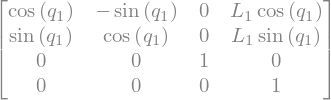

T02:


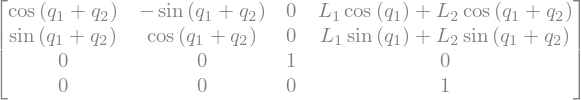


Body Jacobians:
J_b1:


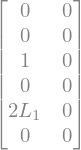

J_b2:


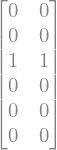


Spatial Inertia Matrices:
G1:


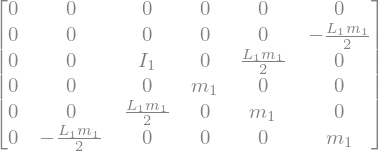

G2:


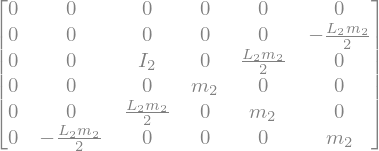


Kinetic Energy:



Potential Energy:


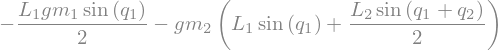


Lagrangian:


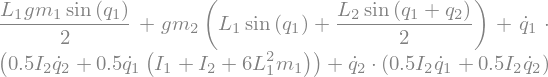


Equations of Motion:
Joint 1:


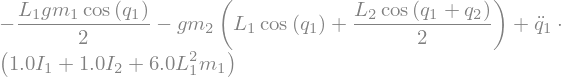

Joint 2:


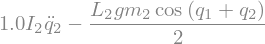

In [15]:
def example_lagrangian_derivation():
    # Define robot parameters
    joint_types = ['revolute', 'revolute']
    joint_axes = [[0, 0, 1], [0, 0, 1]]
    link_lengths = {
        'L1': sf.Symbol("L1", positive=True),
        'L2': sf.Symbol("L2", positive=True)
    }
    joint_points = [[0, 0, 0], [link_lengths['L1'], 0, 0]]

    # Create robot model
    joint_angles, screw_axes_params, _ = create_robot_model(joint_types, joint_axes, link_lengths, joint_points)
    
    print("Joint Angles:")
    display(joint_angles)
    print("\nScrew Axes Parameters:")
    display(screw_axes_params)

    # Create joint velocities
    joint_velocities = values.Values()
    for i in range(len(joint_angles)):
        joint_velocities[f'qdot{i+1}'] = sf.Symbol(f'qdot{i+1}')
    
    print("\nJoint Velocities:")
    display(joint_velocities)

    # Create home configurations
    M_home = values.Values(
        M1=geo.Pose3(R=geo.Rot3.identity(), t=sf.V3([link_lengths['L1'], 0, 0])),
        M2=geo.Pose3(R=geo.Rot3.identity(), t=sf.V3([link_lengths['L1'] + link_lengths['L2'], 0, 0]))
    )
    
    print("\nHome Configurations:")
    display(M_home)

    # Calculate forward kinematics
    T0i_list = n_link_forward_kinematics(joint_angles, screw_axes_params, M_home, sf.numeric_epsilon)
    
    print("\nForward Kinematics:")
    for i, T in enumerate(T0i_list):
        print(f"T0{i+1}:")
        display(T)

    # Clean and simplify the transformations
    T0i_list_cleaned = clean_and_simplify_transformations(T0i_list)
    
    print("\nCleaned and Simplified Forward Kinematics:")
    for i, T in enumerate(T0i_list_cleaned):
        print(f"T0{i+1}:")
        display(T)

    # Calculate body Jacobians
    J_bi_list = calculate_body_jacobians(T0i_list_cleaned, joint_angles, screw_axes_params)
    
    print("\nBody Jacobians:")
    for i, J in enumerate(J_bi_list):
        print(f"J_b{i+1}:")
        display(J)

    # Create robot model with spatial inertia matrices
    m1, m2 = sf.Symbol('m1', positive=True), sf.Symbol('m2', positive=True)
    I1, I2 = sf.Symbol('I1'), sf.Symbol('I2')
    robot_model = {
        'links': [
            {'G': create_spatial_inertia_matrix(m1, sf.V3([link_lengths['L1']/2, 0, 0]), sf.Matrix33.diag([0, 0, I1]))},
            {'G': create_spatial_inertia_matrix(m2, sf.V3([link_lengths['L2']/2, 0, 0]), sf.Matrix33.diag([0, 0, I2]))}
        ]
    }
    
    print("\nSpatial Inertia Matrices:")
    for i, link in enumerate(robot_model['links']):
        print(f"G{i+1}:")
        display(link['G'])

    # Calculate kinetic energy
    T = calculate_kinetic_energy(robot_model, J_bi_list, joint_velocities)
    
    print("\nKinetic Energy:")
    display(T)

    # Calculate potential energy
    V = calculate_potential_energy(robot_model, T0i_list_cleaned)
    
    print("\nPotential Energy:")
    display(V)

    # Calculate Lagrangian
    L = T - V
    
    print("\nLagrangian:")
    display(L)

    # Derive equations of motion
    eom = derive_equations_of_motion(L, joint_angles, joint_velocities)
    
    print("\nEquations of Motion:")
    for i, eq in enumerate(eom):
        print(f"Joint {i+1}:")
        display(eq)

# Run the example
example_lagrangian_derivation()

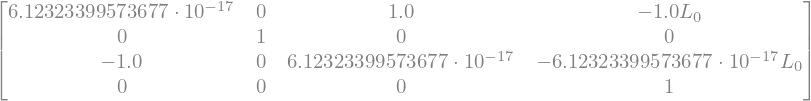

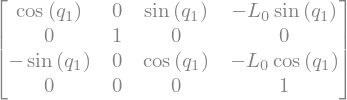

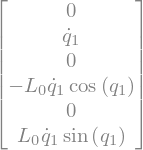

In [16]:
import numpy as np
display(cleaned_T0i[0].subs({joint_angles['q1']:np.pi/2}))
display(cleaned_T0i[0])
display(calculate_spatial_twist(cleaned_T0i[0],joint_angles))